from  https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

# Transfer learning with TensorFlow Hub


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# !pip install tensorflow[and-cuda]
# !pip install tf_keras

# !pip install --upgrade tensorflow-hub
# !pip3 install scikit-learn
# !pip3 install seaborn

## Setup

In [3]:
import os, pathlib

import numpy as np
import time
import datetime


import PIL.Image as Image
import matplotlib.pylab as plt

os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

%load_ext tensorboard

2024-12-18 01:54:43.532394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734486883.565072    3293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734486883.573781    3293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 01:54:43.619583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [5]:
tf.config.experimental.set_memory_growth(gpus[0], enable=True)

## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [6]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [7]:
IMAGE_SHAPE = (224, 224)
hub_layer = hub.KerasLayer(classifier_model,
                                        input_shape=IMAGE_SHAPE+(3,))
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
    # tf.keras.layers.Lambda(lambda x: hub_layer(x))
])

I0000 00:00:1734486886.749693    3293 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


### Run it on a single image

Download a single image to try the model on:

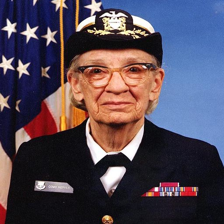

In [8]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [10]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

I0000 00:00:1734486890.274701    3361 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 [==============================] - 2s 2s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [11]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

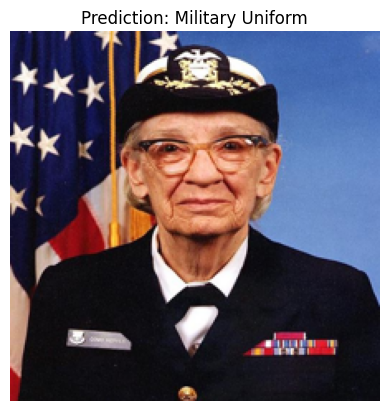

In [13]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

In [14]:
!pwd
# ! ls -la ./../../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45
! ls -la ./../../../Data/MultiModalGenAI/resisc45

/workspace/repos/MultiModalGenAI/src
total 417972
drwxrwxrwx 1 1000 1000      4096 Dec 16 05:07 .
drwxrwxrwx 1 1000 1000      4096 Dec 16 02:11 ..
drwxrwxrwx 1 1000 1000      4096 Dec 16 00:33 NWPU-RESISC45
-rwxrwxrwx 1 1000 1000 427389445 Dec 16 00:27 NWPU-RESISC45.zip
drwxrwxrwx 1 1000 1000      4096 Dec 16 05:08 NWPU-RESISC45_small
-rwxrwxrwx 1 1000 1000    120706 Dec 16 00:27 resisc45-test.txt
-rwxrwxrwx 1 1000 1000    362554 Dec 16 00:27 resisc45-train.txt
-rwxrwxrwx 1 1000 1000    120137 Dec 16 00:27 resisc45-val.txt


In [15]:
# data_dir = './../../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45'
data_dir = './../../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45_small'
dataset_path = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(dataset_path.glob('*/*.jpg')))
print(image_count)

4200


First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [16]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_path),
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_path),
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 4200 files belonging to 6 classes.
Using 2520 files for training.
Found 4200 files belonging to 6 classes.
Using 1680 files for validation.


The flowers dataset has five classes:

In [17]:
class_names = np.array(train_ds.class_names)
print(class_names)

['desert' 'forest' 'lake' 'meadow' 'mountain' 'river']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2024-12-18 01:55:01.852491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [21]:
result_batch = classifier.predict(train_ds)

79/79 [==============================] - 10s 93ms/step


In [22]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['doormat', 'velvet', 'cliff', ..., 'wool', 'valley',
       'hen-of-the-woods'], dtype='<U30')

Check how these predictions line up with the images:

<Figure size 1000x900 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'doormat')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'cliff')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'whiptail')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'megalith')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'sidewinder')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'chiton')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'nematode')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'flatworm')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'eel')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'monastery')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'volcano')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'beaver')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'sea cucumber')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'hen-of-the-woods')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'velvet')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

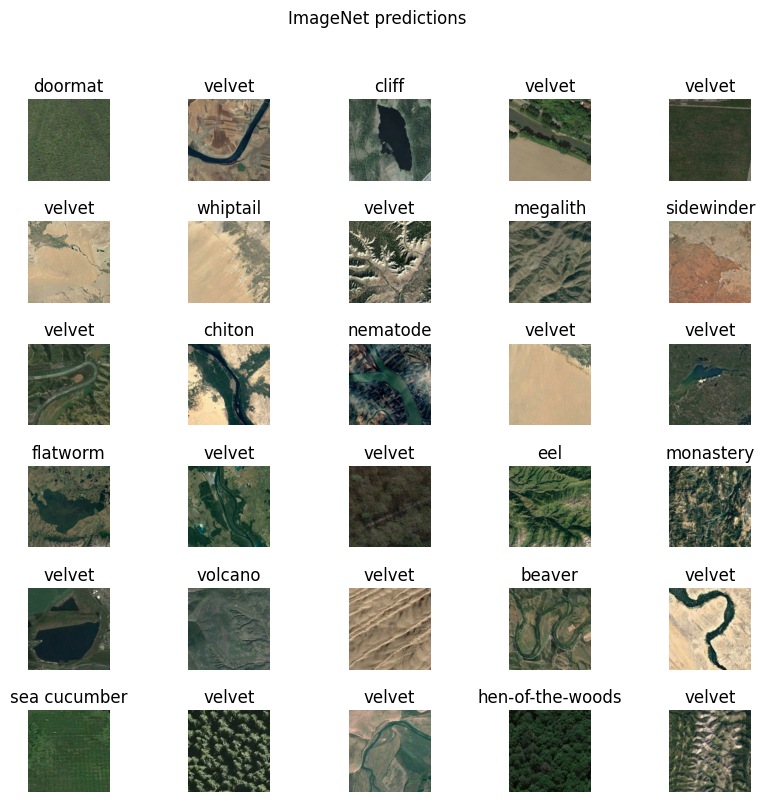

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [24]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [25]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [26]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [27]:
num_classes = len(class_names)

# model = tf_keras.Sequential([
model = tf.keras.Sequential([
    feature_extractor_layer,
    # tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x)),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [28]:
predictions = model(image_batch)

In [29]:
predictions.shape

TensorShape([32, 6])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [30]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [31]:
NUM_EPOCHS = 5

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/5


I0000 00:00:1734486919.103130    3359 service.cc:148] XLA service 0x7f289d11a560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734486919.103357    3359 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-12-18 01:55:19.127704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734486919.301010    3359 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 20s 207ms/step - loss: 0.6492 - acc: 0.7762 - val_loss: 0.3874 - val_acc: 0.8679
Epoch 2/5
79/79 [==============================] - 15s 192ms/step - loss: 0.2744 - acc: 0.9139 - val_loss: 0.3047 - val_acc: 0.8970
Epoch 3/5
79/79 [==============================] - 16s 201ms/step - loss: 0.2072 - acc: 0.9341 - val_loss: 0.2693 - val_acc: 0.9077
Epoch 4/5
79/79 [==============================] - 16s 208ms/step - loss: 0.1675 - acc: 0.9520 - val_loss: 0.2498 - val_acc: 0.9125
Epoch 5/5
79/79 [==============================] - 26s 336ms/step - loss: 0.1396 - acc: 0.9611 - val_loss: 0.2375 - val_acc: 0.9179


Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [32]:
# %tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [33]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 440ms/step
['meadow' 'river' 'lake' 'meadow' 'meadow' 'desert' 'desert' 'mountain'
 'mountain' 'desert' 'river' 'river' 'river' 'desert' 'lake' 'lake'
 'river' 'forest' 'mountain' 'mountain' 'lake' 'mountain' 'mountain'
 'river' 'river' 'meadow' 'forest' 'river' 'forest' 'mountain' 'river'
 'river']


Plot the model predictions:

In [34]:
type(predicted_label_batch[n])

numpy.str_

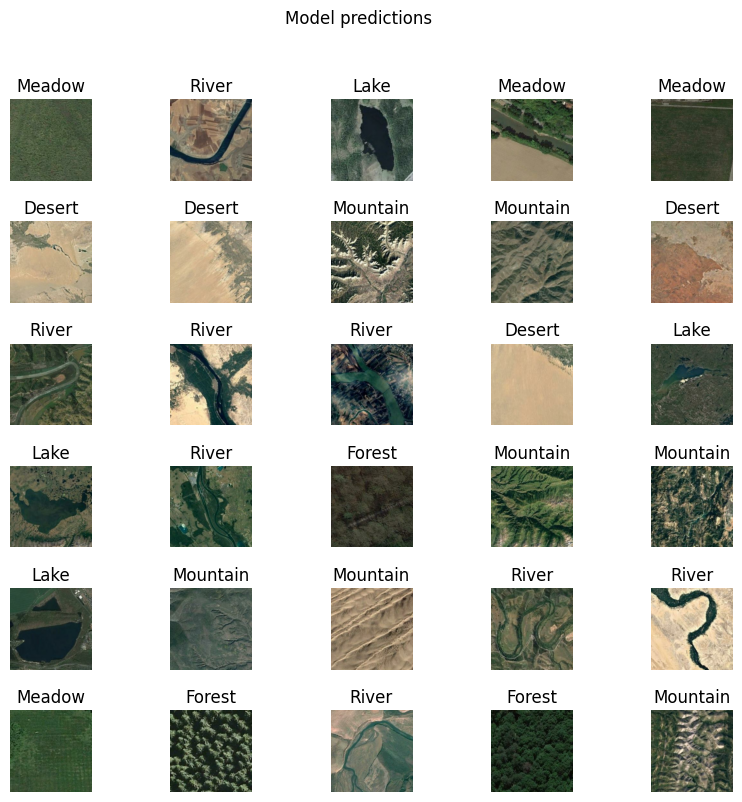

In [35]:
_ = plt.figure(figsize=(10,9))
_ = plt.subplots_adjust(hspace=0.5)

for n in range(30):
  _ = plt.subplot(6,5,n+1)
  _ = plt.imshow(image_batch[n])
  _ = plt.title(predicted_label_batch[n].title())
  _ = plt.axis('off')
_ = plt.suptitle("Model predictions")

In [36]:
for image_batch_val, labels_batch_val in val_ds:
  print(image_batch_val.shape)
  print(labels_batch_val.shape)
  break

(32, 224, 224, 3)
(32,)


In [37]:
type(labels_batch_val[n])

tensorflow.python.framework.ops.EagerTensor

In [38]:
predicted_batch_val = model.predict(image_batch_val)
predicted_id_val = tf.math.argmax(predicted_batch_val, axis=-1)
predicted_label_batch_val = class_names[predicted_id_val]
print(predicted_label_batch_val)

1/1 [==============================] - 0s 39ms/step
['mountain' 'mountain' 'forest' 'meadow' 'mountain' 'meadow' 'lake'
 'forest' 'meadow' 'meadow' 'forest' 'meadow' 'desert' 'lake' 'river'
 'river' 'forest' 'forest' 'river' 'mountain' 'desert' 'forest' 'desert'
 'desert' 'lake' 'forest' 'desert' 'lake' 'desert' 'desert' 'lake'
 'mountain']


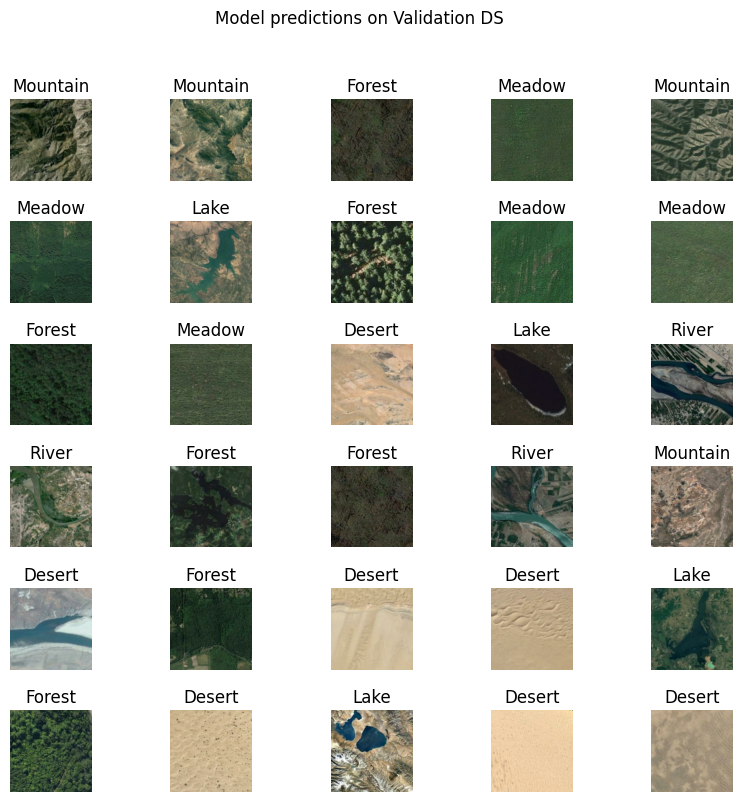

In [39]:
_ = plt.figure(figsize=(10,9))
_ = plt.subplots_adjust(hspace=0.5)

for n in range(30):
  _ = plt.subplot(6,5,n+1)
  _ = plt.imshow(image_batch_val[n])
  _ = plt.title(predicted_label_batch_val[n].title() ) #+ '. R: '+ class_names[ np.argmax(labels_batch_val[n].numpy(), axis=-1)]
  _ = plt.axis('off')
_ = plt.suptitle("Model predictions on Validation DS")

In [40]:
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)
validation_labels1 = tf.concat([y for x, y in val_ds], axis=0).numpy()

2024-12-18 01:56:52.494952: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-18 01:56:52.513895: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
validation_labels.shape
validation_labels1.shape

(1680,)

(1680,)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [44]:
# Predict and generate confusion matrix and classification report
prediction = model.predict(val_ds)
score = model.evaluate(val_ds, verbose=0)
validation_pred = np.argmax(prediction, axis = 1)
cm = confusion_matrix(validation_labels, validation_pred)

53/53 [==============================] - 4s 83ms/step


<Figure size 900x900 with 0 Axes>

<Axes: >

Text(83.22222222222221, 0.5, 'Actual label')

Text(0.5, 137.22222222222217, 'Predicted label')

Text(0.5, 1.0, 'Model Accuracy Score: 91.79%')

              precision    recall  f1-score   support

      desert       0.93      0.90      0.92       286
      forest       0.97      0.91      0.94       277
        lake       0.95      0.89      0.92       294
      meadow       0.89      0.96      0.92       282
    mountain       0.89      0.93      0.91       269
       river       0.89      0.91      0.90       272

    accuracy                           0.92      1680
   macro avg       0.92      0.92      0.92      1680
weighted avg       0.92      0.92      0.92      1680



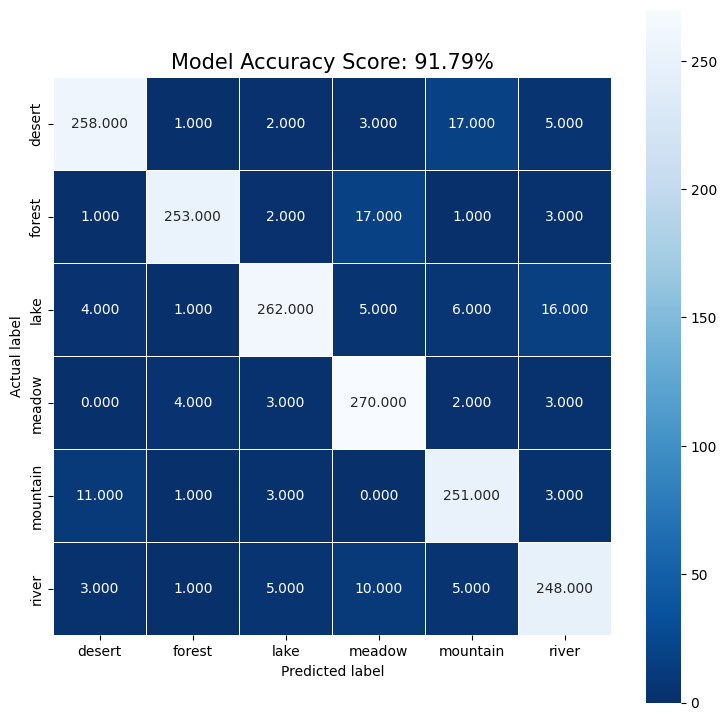

In [45]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title, size = 15)

print(classification_report(validation_labels, validation_pred, target_names=class_names))

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.